#Step 1: Introduction and Data Loading

## 1.1 Introduction and Problem Definition
### Instagram Likes Prediction
In this notebook, we aim to predict the number of likes for Instagram posts using both traditional machine learning methods and advanced deep learning techniques like CLIP Vision Transformers. The task involves building regression and classification models to identify key features that drive engagement.

We'll explore various features from both image content and metadata, extract embeddings using the CLIP model, and compare different machine learning models to find the best-performing approach.


## 1.2 Importing Libraries

In [3]:
pip install torch pillow


In [4]:
pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bsj3ffv5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bsj3ffv5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=e6f8ab32a5d25a1a7e7fe60fd81c2c59bc0f4a306ed3d4d36b5edf69c8718662
  Stored in directory: /tmp/pip-ephem-wheel-cache-6eso4_t6/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For CLIP and image handling
import torch
import clip
from PIL import Image

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor, XGBClassifier

# Ensure you're using a GPU for better performance
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


## 1.3 Loading the Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import zipfile
import os

# Define the path to your zip file
zip_path = '/content/drive/MyDrive/PredictInstaLikes.zip'

# Define the extraction directory
extract_dir = '/content/PredictInstaLikes'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the contents of the extracted folder to verify
os.listdir(extract_dir)

['PredictInstaLikes', '__MACOSX']

In [18]:
metadata = pd.read_csv('/content/PredictInstaLikes/PredictInstaLikes/data/instagram_data.csv')

In [19]:
metadata.head()

,likes,no_of_comments,t,follower_count_at_t,image_path
0,154552,0,1594174009,40934474,../Data/insta_data/0.jpg
1,97386,0,1593571666,40934474,../Data/insta_data/2.jpg
2,145632,0,1593136341,40934474,../Data/insta_data/4.jpg
3,76461,0,1592981047,40934474,../Data/insta_data/6.jpg
4,174620,0,1592703461,40934474,../Data/insta_data/8.jpg


# Step 2: Exploratory Data Analysis (EDA)

## 2.1 Basic EDA and Dataset Overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   likes                3785 non-null   int64 
 1   no_of_comments       3785 non-null   int64 
 2   t                    3785 non-null   int64 
 3   follower_count_at_t  3785 non-null   int64 
 4   image_path           3785 non-null   object
dtypes: int64(4), object(1)
memory usage: 148.0+ KB


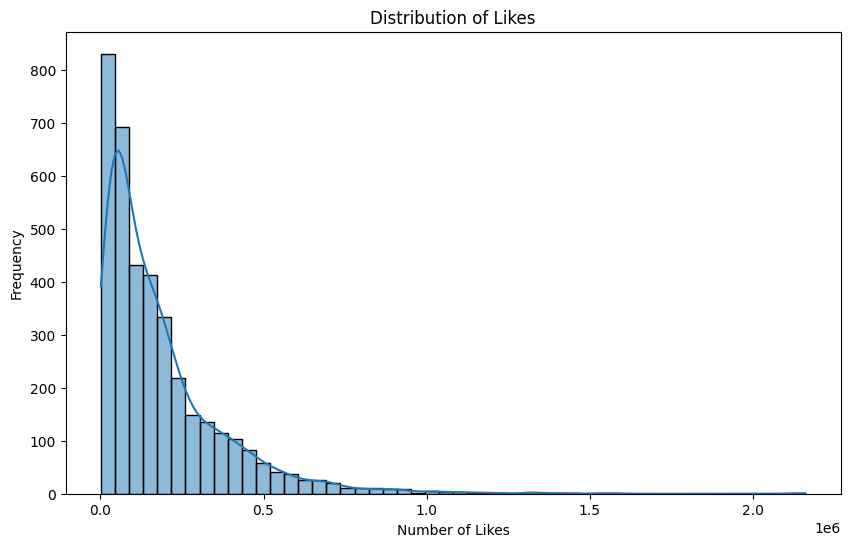

In [20]:
# Check for missing values and data types
metadata.info()

# Describe the dataset for a statistical summary
metadata.describe()

# Visualize the distribution of likes
plt.figure(figsize=(10, 6))
sns.histplot(metadata['likes'], bins=50, kde=True)
plt.title('Distribution of Likes')
plt.xlabel('Number of Likes')
plt.ylabel('Frequency')
plt.show()


## 2.2 Handling Missing Values and Outliers

In [21]:
# Check for missing values
missing_values = metadata.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Assuming there are some missing values, drop or fill them accordingly
metadata.dropna(inplace=True)

# Identify and remove outliers (optional)
# We'll use IQR to identify outliers in 'likes'
Q1 = metadata['likes'].quantile(0.25)
Q3 = metadata['likes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
filtered_data = metadata[(metadata['likes'] >= lower_bound) & (metadata['likes'] <= upper_bound)]

print(f"Data size before removing outliers: {metadata.shape}")
print(f"Data size after removing outliers: {filtered_data.shape}")


Missing values in each column:
 likes                  0
no_of_comments         0
t                      0
follower_count_at_t    0
image_path             0
dtype: int64
Data size before removing outliers: (3785, 5)
Data size after removing outliers: (3573, 5)


# Step 3: Feature Engineering

## 3.1 Feature Engineering: Creating Traditional Features

In [22]:
# Creating additional features based on domain knowledge
filtered_data['engagement_rate'] = filtered_data['likes'] / filtered_data['follower_count_at_t']
filtered_data['log_likes'] = np.log1p(filtered_data['likes'])  # Use log-transform for skewed data
filtered_data['time_of_day'] = pd.to_datetime(filtered_data['t'], unit='s').dt.hour  # Extract hour from timestamp
filtered_data['day_of_week'] = pd.to_datetime(filtered_data['t'], unit='s').dt.weekday  # Extract day of the week

# Display the first few rows with new features
filtered_data.head()


<ipython-input-22-0d8d56957937>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['engagement_rate'] = filtered_data['likes'] / filtered_data['follower_count_at_t']
<ipython-input-22-0d8d56957937>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['log_likes'] = np.log1p(filtered_data['likes'])  # Use log-transform for skewed data
<ipython-input-22-0d8d56957937>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,likes,no_of_comments,t,follower_count_at_t,image_path,engagement_rate,log_likes,time_of_day,day_of_week
0,154552,0,1594174009,40934474,../Data/insta_data/0.jpg,0.003776,11.948292,2,2
1,97386,0,1593571666,40934474,../Data/insta_data/2.jpg,0.002379,11.486448,2,2
2,145632,0,1593136341,40934474,../Data/insta_data/4.jpg,0.003558,11.888845,1,4
3,76461,0,1592981047,40934474,../Data/insta_data/6.jpg,0.001868,11.244549,6,2
4,174620,0,1592703461,40934474,../Data/insta_data/8.jpg,0.004266,12.070373,1,6


## 3.2 Visualizing New Features

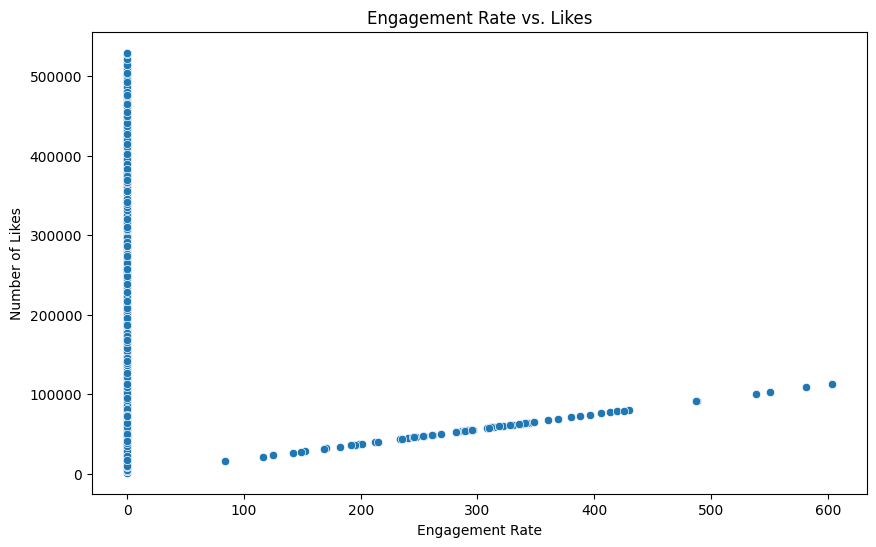

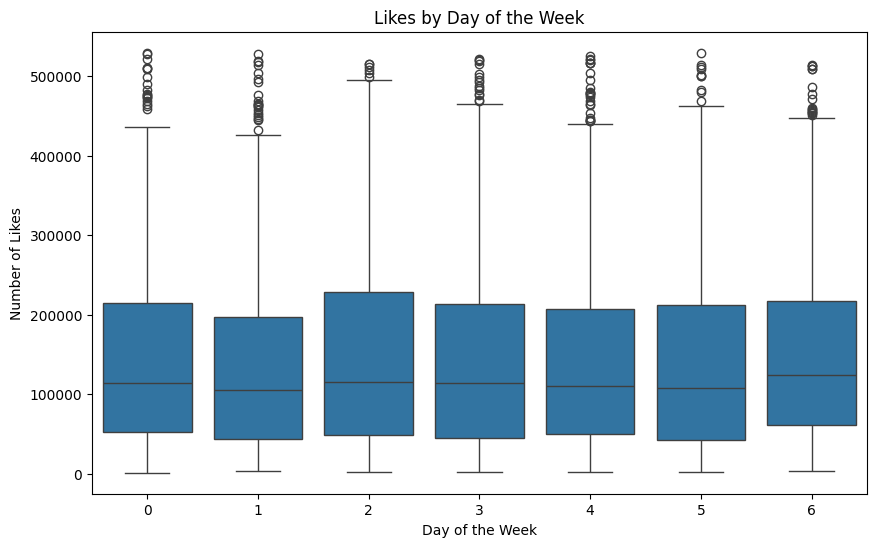

In [23]:
# Visualize the relationship between engagement rate and likes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='engagement_rate', y='likes')
plt.title('Engagement Rate vs. Likes')
plt.xlabel('Engagement Rate')
plt.ylabel('Number of Likes')
plt.show()

# Visualize the distribution of likes across different days of the week
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='likes', data=filtered_data)
plt.title('Likes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Likes')
plt.show()


# Step 4: Image Feature Extraction using CLIP

## 4.1 Extracting Image Features using CLIP

In [24]:
filtered_data['image_path'] = filtered_data['image_path'].str.replace('../Data/insta_data/', 'PredictInstaLikes/PredictInstaLikes/data/insta_data/')

<ipython-input-24-a35c18b16cb4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['image_path'] = filtered_data['image_path'].str.replace('../Data/insta_data/', 'PredictInstaLikes/PredictInstaLikes/data/insta_data/')


In [25]:
# Load the CLIP model and preprocessing function
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to extract features from a single image
def get_image_features(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features.cpu().numpy().flatten()

# Apply CLIP to the dataset
filtered_data['clip_features'] = filtered_data['image_path'].apply(lambda x: get_image_features(x))

# Convert list of features into separate columns
clip_features_df = pd.DataFrame(filtered_data['clip_features'].to_list(), columns=[f'clip_feature_{i}' for i in range(512)])
filtered_data = pd.concat([filtered_data.reset_index(drop=True), clip_features_df], axis=1)

# Drop the original 'clip_features' column to avoid duplication
filtered_data.drop(columns=['clip_features'], inplace=True)
filtered_data.head()


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 50.9MiB/s]
<ipython-input-25-8199858294f3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['clip_features'] = filtered_data['image_path'].apply(lambda x: get_image_features(x))


,likes,no_of_comments,t,follower_count_at_t,image_path,engagement_rate,log_likes,time_of_day,day_of_week,clip_feature_0,...,clip_feature_502,clip_feature_503,clip_feature_504,clip_feature_505,clip_feature_506,clip_feature_507,clip_feature_508,clip_feature_509,clip_feature_510,clip_feature_511
0,154552,0,1594174009,40934474,PredictInstaLikes/PredictInstaLikes/data/insta...,0.003776,11.948292,2,2,0.057651,...,-0.108553,0.117139,0.620004,0.124578,-0.105958,0.400683,-0.223172,0.510831,0.068301,0.279435
1,97386,0,1593571666,40934474,PredictInstaLikes/PredictInstaLikes/data/insta...,0.002379,11.486448,2,2,0.326061,...,-0.078470,0.456307,1.076363,-0.412673,-0.304080,0.000335,-0.026089,0.482395,0.107283,0.030244
2,145632,0,1593136341,40934474,PredictInstaLikes/PredictInstaLikes/data/insta...,0.003558,11.888845,1,4,-0.046568,...,-0.060225,0.240435,0.802390,-0.468989,-0.078236,-0.394853,0.237051,0.628264,0.286947,-0.244369
3,76461,0,1592981047,40934474,PredictInstaLikes/PredictInstaLikes/data/insta...,0.001868,11.244549,6,2,0.117775,...,-0.185489,0.151029,0.748208,-0.375992,0.009244,-0.027637,0.167432,0.015217,0.115579,0.295819
4,174620,0,1592703461,40934474,PredictInstaLikes/PredictInstaLikes/data/insta...,0.004266,12.070373,1,6,-0.157460,...,-0.200956,0.256369,0.859801,-0.710875,0.001316,-0.014512,0.269112,0.581805,-0.402560,0.079929


# Step 5: Splitting the Data into Train/Test Sets

## 5.1 Preparing Data for Training

In [26]:
# Define the target variable
target = 'likes'  # Change this to your classification target if needed (e.g., 'like_category')

# Drop unnecessary columns
traditional_features = ['no_of_comments', 'follower_count_at_t', 'engagement_rate', 'time_of_day', 'day_of_week']

# Extract the traditional features and target
X_traditional = filtered_data[traditional_features]
y = filtered_data[target]

# Include CLIP features
clip_feature_columns = [f'clip_feature_{i}' for i in range(512)]
X_clip = pd.concat([X_traditional, filtered_data[clip_feature_columns]], axis=1)

# Splitting into train and test sets for both versions
X_train_traditional, X_test_traditional, y_train, y_test = train_test_split(X_traditional, y, test_size=0.2, random_state=42)
X_train_clip, X_test_clip, _, _ = train_test_split(X_clip, y, test_size=0.2, random_state=42)

print(f"Traditional Features Shape: {X_train_traditional.shape}")
print(f"CLIP Features Shape: {X_train_clip.shape}")


Traditional Features Shape: (2858, 5)
CLIP Features Shape: (2858, 517)


# Step 6: Model Training and Comparison

## 6.1 Training Regression Model without CLIP Features

In [27]:
# Train a regression model using traditional features
regressor_traditional = LinearRegression()
regressor_traditional.fit(X_train_traditional, y_train)

# Make predictions
y_pred_traditional = regressor_traditional.predict(X_test_traditional)

# Evaluate model performance
mae_traditional = mean_absolute_error(y_test, y_pred_traditional)
print(f"Mean Absolute Error (Traditional Features): {mae_traditional}")


Mean Absolute Error (Traditional Features): 97272.96433000006


## 6.2 Training Regression Models with CLIP Features

In [28]:
# Train a regression model using both traditional and CLIP features
regressor_clip = LinearRegression()
regressor_clip.fit(X_train_clip, y_train)

# Make predictions
y_pred_clip = regressor_clip.predict(X_test_clip)

# Evaluate model performance
mae_clip = mean_absolute_error(y_test, y_pred_clip)
print(f"Mean Absolute Error (With CLIP Features): {mae_clip}")


Mean Absolute Error (With CLIP Features): 81443.1082142197


# Step 7: Comparing Models Using Classification (convert likes into categories)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

def evaluate_model(y_test, y_pred, model_name="Model"):
    """
    Evaluates a classification model's performance.

    Parameters:
    y_test (array-like): True labels of the test set.
    y_pred (array-like): Predicted labels by the model.
    model_name (str): Name of the model (for labeling purposes).

    Returns:
    None
    """
    # Print the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy ({model_name}): {accuracy:.4f}")

    # Print the classification report
    print(f"Classification Report ({model_name}):\n")
    print(classification_report(y_test, y_pred))

    # Plot and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


## 7.1 Converting Likes into Categories

In [32]:
# Convert likes into categories (Low, Medium, High)
like_quantiles = filtered_data['likes'].quantile([0.33, 0.66])
filtered_data['like_category'] = pd.cut(filtered_data['likes'],
                                        bins=[-1, like_quantiles[0.33], like_quantiles[0.66], np.inf],
                                        labels=['Low', 'Medium', 'High'])
# Fit and transform the 'like_category' column
label_encoder = LabelEncoder()
filtered_data['like_category_encoded'] = label_encoder.fit_transform(filtered_data['like_category'])

# Update the target variable for classification
target = 'like_category_encoded'
y_class = filtered_data[target]

# Split the data for classification
X_train_class_traditional, X_test_class_traditional, y_train_class, y_test_class = train_test_split(X_traditional, y_class, test_size=0.2, random_state=42)
X_train_class_clip, X_test_class_clip, _, _ = train_test_split(X_clip, y_class, test_size=0.2, random_state=42)


In [69]:
traditional_features_like = ['no_of_comments', 'follower_count_at_t', 'engagement_rate', 'time_of_day', 'day_of_week', 'likes','like_category_encoded']

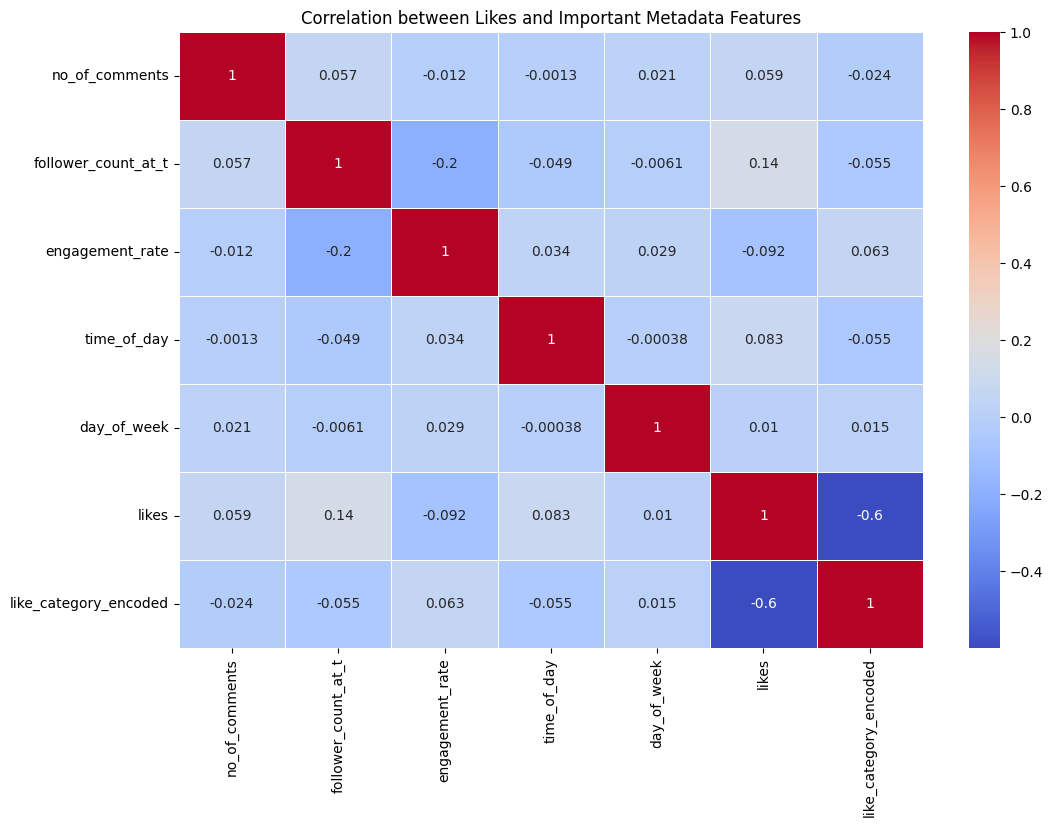

In [70]:
X_traditional_like = filtered_data[traditional_features_like]
# Now plot the correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = X_traditional_like.corr()

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Likes and Important Metadata Features')
plt.show()

## 7.2 Training Classification Model without CLIP Features

In [41]:
# # Train a logistic regression model for classification
# classifier_traditional = Lasso(alpha=0.01) # or any classifier like LogisticRegression()
# classifier_traditional.fit(X_train_class_traditional, y_train_class)

# # Predict and evaluate
# y_pred_class_traditional = classifier_traditional.predict(X_test_class_traditional)

# # Accuracy score
# accuracy_traditional = accuracy_score(y_test_class, y_pred_class_traditional)
# print(f"Accuracy (Traditional Features): {accuracy_traditional}")

from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train_class_traditional, y_train_class)

# Predict and evaluate
y_pred_rf = rf_classifier.predict(X_test_class_traditional)

# Accuracy score
accuracy_traditional = accuracy_score(y_test_class, y_pred_rf)
print(f"Accuracy (Without CLIP Features): {accuracy_traditional}")




Accuracy (Without CLIP Features): 0.958041958041958


Accuracy (Random Forest (Traditional Features)): 0.9580
Classification Report (Random Forest (Traditional Features)):

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       243
           1       0.95      0.97      0.96       230
           2       0.95      0.93      0.94       242

    accuracy                           0.96       715
   macro avg       0.96      0.96      0.96       715
weighted avg       0.96      0.96      0.96       715



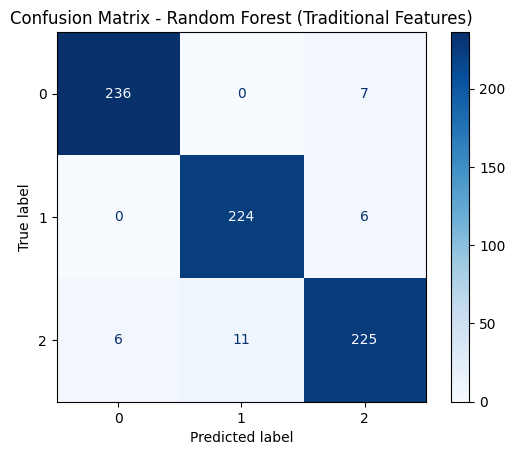

In [42]:
evaluate_model(y_test_class, y_pred_rf, model_name="Random Forest (Traditional Features)")

## 7.3 Training Classification Model with CLIP Features

In [38]:
# Train an XGBoost classifier for combined features
classifier_clip = XGBClassifier()
classifier_clip.fit(X_train_class_clip, y_train_class)

# Predict and evaluate
y_pred_class_clip = classifier_clip.predict(X_test_class_clip)

# Accuracy score
accuracy_clip = accuracy_score(y_test_class, y_pred_class_clip)
print(f"Accuracy (With CLIP Features): {accuracy_clip}")


Accuracy (With CLIP Features): 0.972027972027972


Accuracy (XGBoost (With CLIP Features)): 0.9720
Classification Report (XGBoost (With CLIP Features)):

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       243
           1       0.97      0.97      0.97       230
           2       0.96      0.95      0.96       242

    accuracy                           0.97       715
   macro avg       0.97      0.97      0.97       715
weighted avg       0.97      0.97      0.97       715



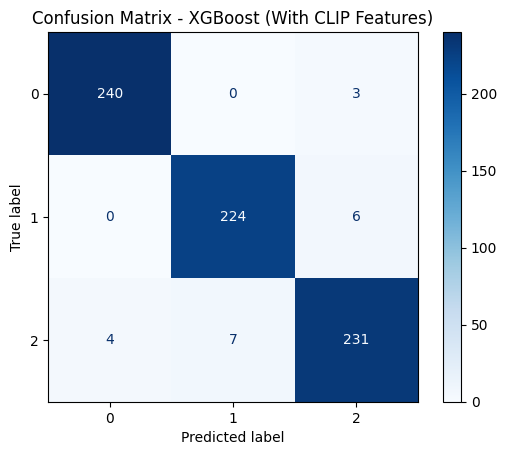

In [39]:
evaluate_model(y_test_class, y_pred_class_clip, model_name="XGBoost (With CLIP Features)")

# Step 8: Visualizing and Comparing Results

## 8.1 Comparison of Model Performance

<ipython-input-44-5c54a902a0f2>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results_regression, palette="Blues")


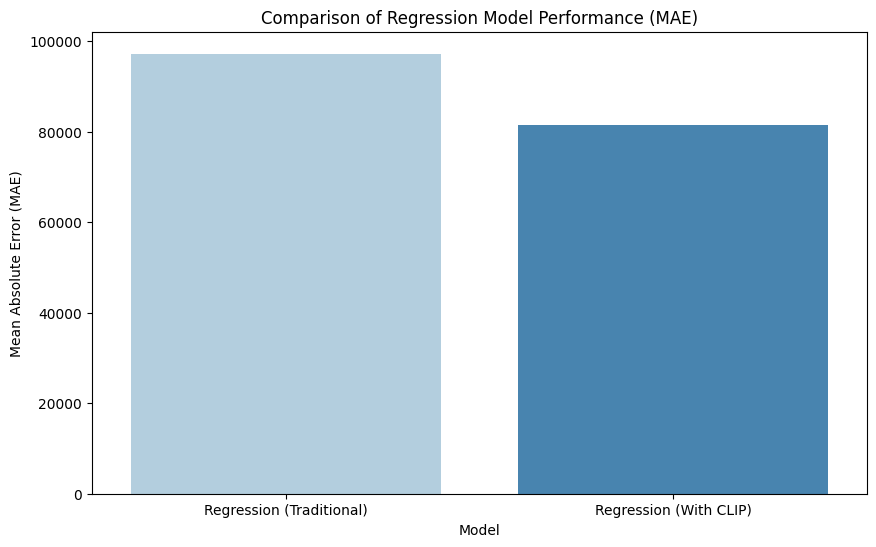

In [44]:
# Assuming mae_traditional and mae_clip have been calculated
results_regression = pd.DataFrame({
    'Model': ['Regression (Traditional)', 'Regression (With CLIP)'],
    'MAE': [mae_traditional, mae_clip]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', data=results_regression, palette="Blues")
plt.title('Comparison of Regression Model Performance (MAE)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Model')
plt.show()


<ipython-input-45-b6d8023a6e63>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_classification, palette="Greens")


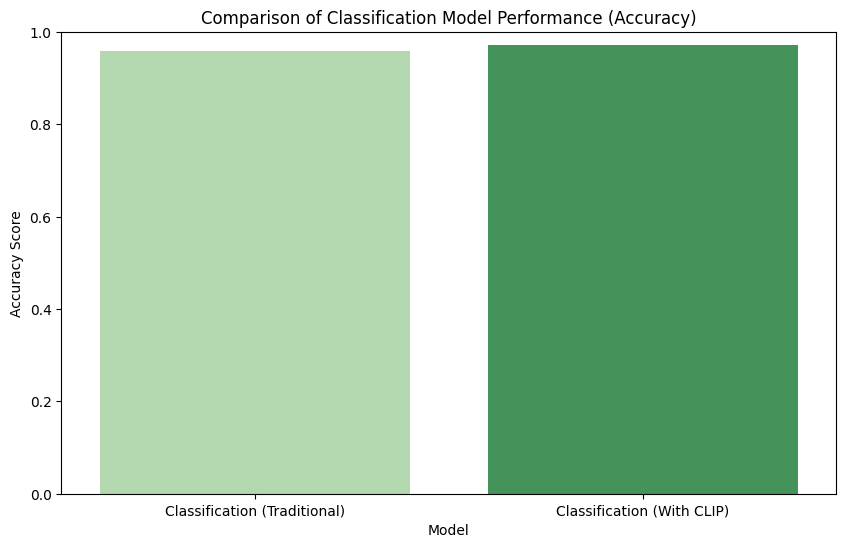

In [45]:
# Assuming accuracy_traditional and accuracy_clip have been calculated
results_classification = pd.DataFrame({
    'Model': ['Classification (Traditional)', 'Classification (With CLIP)'],
    'Accuracy': [accuracy_traditional, accuracy_clip]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_classification, palette="Greens")
plt.title('Comparison of Classification Model Performance (Accuracy)')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.ylim(0, 1)  # Ensure the y-axis goes from 0 to 1
plt.show()


# Maximize the accuracy of the classification task using CLIP features combined with traditional features

## Step 1: Feature Selection and Understanding

## 1.1 Feature Importance Using Tree-Based Models

<ipython-input-46-e7741a9cad7a>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_importance_df['Feature'][:20], x=feature_importance_df['Importance'][:20], palette="viridis")


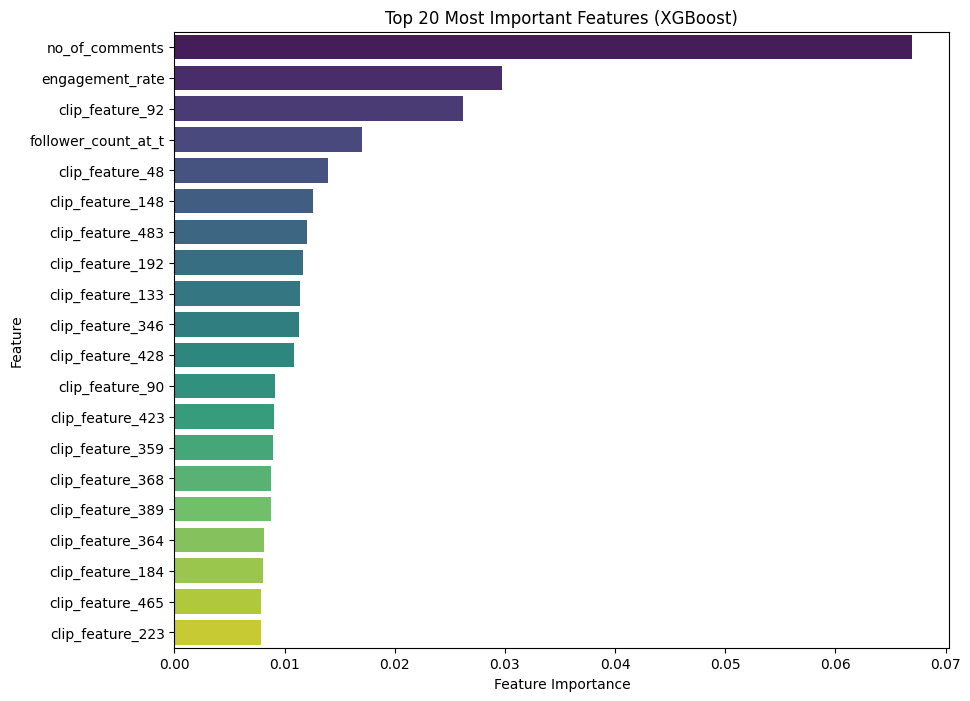

In [46]:
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train an XGBoost model with default parameters to identify feature importance
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_class_clip, y_train_class)

# Get feature importance scores
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to visualize the importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train_class_clip.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 8))
sns.barplot(y=feature_importance_df['Feature'][:20], x=feature_importance_df['Importance'][:20], palette="viridis")
plt.title('Top 20 Most Important Features (XGBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


In [48]:
# Select the top 20 most important features
selected_features = feature_importance_df['Feature'][:20].values

# Display the selected features
print("Selected Features:", selected_features)

Selected Features: ['no_of_comments' 'engagement_rate' 'clip_feature_92'
 'follower_count_at_t' 'clip_feature_48' 'clip_feature_148'
 'clip_feature_483' 'clip_feature_192' 'clip_feature_133'
 'clip_feature_346' 'clip_feature_428' 'clip_feature_90'
 'clip_feature_423' 'clip_feature_359' 'clip_feature_368'
 'clip_feature_389' 'clip_feature_364' 'clip_feature_184'
 'clip_feature_465' 'clip_feature_223']


## 2.2 Training the Final Model with Optimal Parameters

In [51]:
X_selected=X_clip[selected_features]

In [52]:
X_selected

,no_of_comments,engagement_rate,clip_feature_92,follower_count_at_t,clip_feature_48,clip_feature_148,clip_feature_483,clip_feature_192,clip_feature_133,clip_feature_346,clip_feature_428,clip_feature_90,clip_feature_423,clip_feature_359,clip_feature_368,clip_feature_389,clip_feature_364,clip_feature_184,clip_feature_465,clip_feature_223
0,0,0.003776,-7.216935,40934474,0.077192,0.081085,-0.111792,0.299771,0.990017,0.305524,0.705900,0.169504,-0.781176,-0.102748,0.270822,0.763685,-0.634093,-0.102882,0.437547,-0.419403
1,0,0.002379,-6.343468,40934474,0.180980,0.015515,-0.050463,0.149850,0.835166,-0.167089,-1.885980,0.237198,-0.178980,0.108473,-0.116612,2.188010,-0.334281,-0.103413,-0.197281,-0.337839
2,0,0.003558,-7.426634,40934474,-0.029752,0.131238,0.087226,-0.222963,0.964540,0.240727,-1.252333,0.133912,0.019675,-0.127043,-0.091048,2.231650,0.519240,-0.191330,-0.062867,-0.624687
3,0,0.001868,-6.682884,40934474,0.364107,-0.256031,0.128759,0.300178,0.918994,-0.122651,-0.930347,0.573254,-1.314616,0.058384,0.136679,1.892863,-0.327121,-0.160233,-0.136669,-0.773135
4,0,0.004266,-6.605121,40934474,-0.162463,-0.189021,0.399088,0.229288,0.977044,0.176884,-1.789257,0.368685,-0.447019,0.225372,0.274509,1.384573,0.442801,-0.419328,-0.235923,0.185778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,6029,0.080833,-3.666993,4229627,0.508618,0.193200,0.267949,-0.015680,0.775525,-0.024747,-0.826893,0.116369,0.016712,-0.115750,0.219612,1.273797,-0.529451,0.137921,0.440511,-0.502461
3569,2591,0.051327,-3.473847,4229627,0.659391,0.168768,-0.117087,-0.267241,0.734040,0.062507,-0.738958,0.164171,-0.319042,0.100967,-0.120547,0.751749,-0.827171,-0.429696,-0.202742,-0.110081
3570,253,0.004233,-2.463433,4229627,0.202300,-0.897391,0.455135,0.179605,0.621515,-0.660152,-1.936920,-0.326945,0.324142,-0.015479,-0.157349,2.648919,0.110163,-0.118901,-0.155136,-0.258324
3571,1175,0.033500,-5.711658,4229627,0.131743,0.071381,-0.039200,0.056000,0.877068,0.458610,1.795058,0.053331,0.291133,0.539671,-0.497300,-0.529175,-0.620900,0.560609,0.000294,-0.058879


In [53]:
X_selected_train_class_clip, X_test_class_clip, _, _ = train_test_split(X_selected, y_class, test_size=0.2, random_state=42)

In [55]:
# Train an XGBoost classifier for combined features
classifier_clip = XGBClassifier()
classifier_clip.fit(X_selected_train_class_clip, y_train_class)

# Predict and evaluate
y_pred_class_clip = classifier_clip.predict(X_test_class_clip)

# Accuracy score
accuracy_clip = accuracy_score(y_test_class, y_pred_class_clip)
print(f"Accuracy (With selected CLIP Features): {accuracy_clip}")


Accuracy (With selected CLIP Features): 0.9762237762237762


Accuracy (XGBoost (With CLIP Features)): 0.9762
Classification Report (XGBoost (With CLIP Features)):

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       243
           1       0.98      0.98      0.98       230
           2       0.96      0.97      0.97       242

    accuracy                           0.98       715
   macro avg       0.98      0.98      0.98       715
weighted avg       0.98      0.98      0.98       715



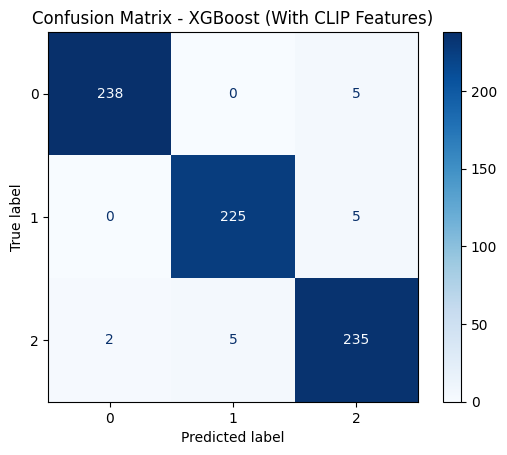

In [56]:
evaluate_model(y_test_class, y_pred_class_clip, model_name="XGBoost (With CLIP Features)")

Accuracy (Stacking Classifier): 0.9734
Classification Report (Stacking Classifier):

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       243
           1       0.97      0.98      0.97       230
           2       0.96      0.96      0.96       242

    accuracy                           0.97       715
   macro avg       0.97      0.97      0.97       715
weighted avg       0.97      0.97      0.97       715



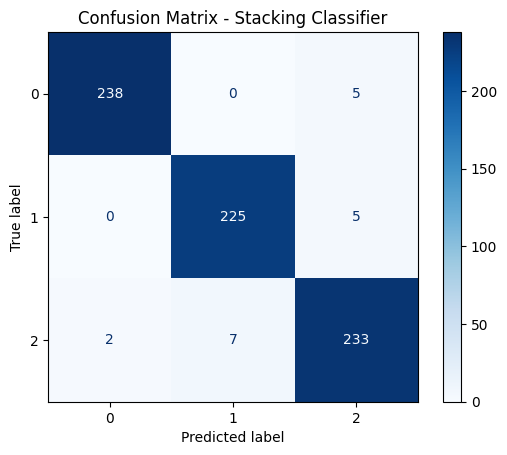

In [58]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC


# Define base models
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

# Create a stacking classifier
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression())

# Train the stacking classifier
stacking_clf.fit(X_selected_train_class_clip, y_train_class)

# Evaluate the model
y_pred_stack = stacking_clf.predict(X_test_class_clip)
evaluate_model(y_test_class, y_pred_stack, model_name="Stacking Classifier")


Accuracy (XGBoost with PCA): 0.7958
Classification Report (XGBoost with PCA):

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       243
           1       0.86      0.84      0.85       230
           2       0.72      0.69      0.71       242

    accuracy                           0.80       715
   macro avg       0.80      0.80      0.80       715
weighted avg       0.79      0.80      0.80       715



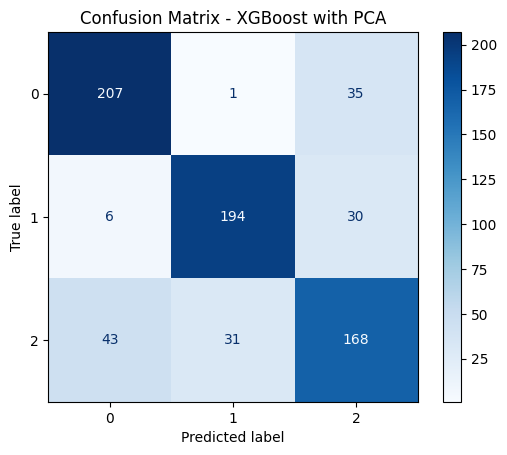

In [59]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=20)  # Choose an appropriate number of components
X_train_pca = pca.fit_transform(X_selected_train_class_clip)
X_test_pca = pca.transform(X_test_class_clip)

# Retrain the model using PCA-transformed features
xgb_model_pca = XGBClassifier(random_state=42)
xgb_model_pca.fit(X_train_pca, y_train_class)

# Evaluate
y_pred_pca = xgb_model_pca.predict(X_test_pca)
evaluate_model(y_test_class, y_pred_pca, model_name="XGBoost with PCA")


In [61]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00


Accuracy (CatBoost Classifier): 0.9692
Classification Report (CatBoost Classifier):

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       243
           1       0.96      0.97      0.97       230
           2       0.96      0.95      0.95       242

    accuracy                           0.97       715
   macro avg       0.97      0.97      0.97       715
weighted avg       0.97      0.97      0.97       715



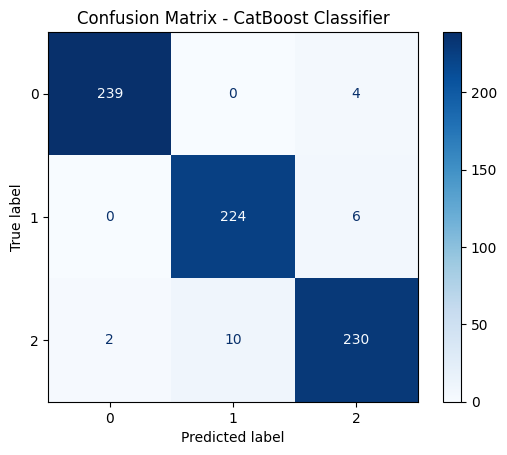

In [62]:
from catboost import CatBoostClassifier

# Train a CatBoost model
catboost_clf = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=6, random_state=42, verbose=0)
catboost_clf.fit(X_selected_train_class_clip, y_train_class)

# Evaluate
y_pred_catboost = catboost_clf.predict(X_test_class_clip)
evaluate_model(y_test_class, y_pred_catboost, model_name="CatBoost Classifier")


# Final Result

## Classification

Accuracy (CatBoost Classifier): 0.9692

Accuracy (XGBoost with PCA): 0.7958

Accuracy (XGBoost (With selected CLIP Features)): 0.9762

Accuracy (XGBoost (With CLIP Features)): 0.9720

Accuracy (Random Forest (Traditional Features)): 0.9580

## Regression

Mean Absolute Error (Traditional Features): 97272.96433000006

Mean Absolute Error (With CLIP Features): 81443.1082142197